In [5]:
import pandas as pd
import numpy as np
import os
from collections import OrderedDict
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F

# Parse DRF Files to get Relevant Data

In [6]:
def generate_master_df(path, num_races):
    '''
        Generate the master dataframe from which we will create our training/testing data
        
        Args:
            path (string): Path to directory containing DRF files to parse
            num_races (int): Number of races to use in each sequence (how many races back
                             are we looking?)
        
        Returns: Dataframe containing all data from each DRF concatted together
    '''
    # Cap num_races
    num_races = min(num_races, 9) # Only have max of 9 prev race's data
    
    # Get all DRF files in data directory
    filenames = [path+file for file in os.listdir(path) if file.endswith(".DRF")]
    
    # Iterate through each file and concat data to master df
    master_df = None
    for ii, file in tqdm(enumerate(filenames)): 
        if ii == 0:
            # First pass through just create master df
            df = pd.read_csv(file, header=None)
            master_df = slice_df(df, num_races)
        else:
            # All other passes, append sliced dataframe to master
            df = pd.read_csv(file, header=None)
            df = slice_df(df, num_races)
            master_df = master_df.append(df, ignore_index=True)
            
    # Drop all rows containing NaN values (these horses didn't have enough prev races)
    return master_df.dropna().reset_index().drop(['index'], axis=1)

def slice_df(df, num_races=3):
    # Define columns to grab
    column_ids = OrderedDict({
        'horse_age': (46,47),
        'days_since_prev_race': (266, 266+num_races),
        'distance': (316, 316+num_races),
        'num_entrants': (346, 346+num_races),
        'post_position': (356, 356+num_races),
        'weight': (506, 506+num_races),
        'label': (1036, 1036+num_races) # Finish time
    })

    # Select all of our column ranges
    rng = []
    col_names = []
    for k,v in column_ids.items():
        # Append range to rng -- special case for single field
        if v[1] - v[0] == 1:
            for i in range(num_races):
                rng += [v[0]]
                col_names.append('{}_{}'.format(k, i))
        else:
            # Handle column ranges
            rng += range(v[0],v[1])
            for ii in range(v[0], v[1]):
                col_names.append('{}_{}'.format(k, ii-v[0]))

    # Slice df on columns
    ret = df.loc[:, rng]
    ret.columns = col_names
    return ret

In [7]:
days_in_sequence = 3
master_df = generate_master_df('./input_files/', days_in_sequence)
master_df.head(5)

419it [00:43,  9.51it/s]


,horse_age_0,horse_age_1,horse_age_2,days_since_prev_race_0,days_since_prev_race_1,days_since_prev_race_2,distance_0,distance_1,distance_2,num_entrants_0,...,num_entrants_2,post_position_0,post_position_1,post_position_2,weight_0,weight_1,weight_2,label_0,label_1,label_2
0,3,3,3,42.0,8.0,11.0,300.0,350.0,350.0,8.0,...,10.0,6.0,4.0,7.0,126.0,126.0,126.0,15.79,18.04,17.69
1,3,3,3,7.0,14.0,78.0,400.0,330.0,400.0,6.0,...,7.0,2.0,7.0,6.0,126.0,126.0,126.0,20.22,17.50,20.40
2,3,3,3,14.0,14.0,7.0,300.0,220.0,300.0,8.0,...,9.0,1.0,4.0,6.0,131.0,129.0,126.0,15.56,12.04,15.35
3,2,2,2,14.0,7.0,14.0,330.0,300.0,330.0,7.0,...,7.0,3.0,5.0,1.0,127.0,127.0,127.0,17.12,15.86,17.50
4,3,3,3,33.0,16.0,22.0,350.0,300.0,350.0,9.0,...,8.0,7.0,1.0,4.0,128.0,131.0,126.0,18.16,15.92,18.76


# Create Dataloader
Create a generator that can parse through the master dataframe, and create batches of training data. These batches will have the shape (days_in_sequence, batch_size, input_features).

In [30]:
import re

# Section off data by race -- list of tuples (race_num, data)
race_data = []
for ii in range(days_in_sequence):
    # Match all collumns for this race
    pattern = re.compile('.*_{}'.format(ii))
    cols = [pattern.match(col).string for col in master_df.columns if pattern.match(col) != None]
    # Get data from these columns
    data = master_df.loc[:, cols]
    # Rename columns
    cols = [col[:-2] for col in cols]
    data.columns = cols
    # Append to race data
    race_data.append((ii, data)) 
    
# Break race_data into input_data and label_data
input_data = []
labels = []
for race_tup in race_data:
    input_data.append(race_tup[1].drop(['label'], axis=1).values)
    labels.append(race_tup[1]['label'].values)
    
# Want data to go in reverse order (oldest races first)
input_data.reverse()
labels.reverse()

In [31]:
def dataloader(data, labels, days_in_sequence=3, batch_size=10, input_features=6):
    # Truncate data to ensure only full batches
    num_horses = len(data[0])
    cutoff = (num_horses//batch_size)*batch_size
    trunc_data = [race[:cutoff] for race in data]
    trunc_labels = [race[:cutoff] for race in labels]
    
    # Create our batches
    for ii in range(0, cutoff, batch_size):
        # Get data for this batch
        batch_data = [race[ii:ii+batch_size] for race in trunc_data]
        batch_labels = [race[ii: ii+batch_size] for race in trunc_labels]
        
        # Create batch tensor of correct size -- days_in_sequence X batch_size X input_features
        batch = torch.zeros((days_in_sequence, batch_size, input_features), dtype=torch.float64)
        
        # Fill in batch tensor
        for batch_col in range(0, batch_size):
            # Create sequence -- grab horse data from each race -- and add to batch
            sequence = torch.tensor([batch_data[i][batch_col] for i in range(0, days_in_sequence)])
            batch[:, batch_col] = sequence
            
        # Create label tensor
        label_tensor = torch.tensor(batch_labels[-1], dtype=torch.float64)
        
        yield batch, label_tensor
    
    
test = dataloader(input_data, labels)
sample_batch, sample_label = next(iter(dataloader(input_data, labels, batch_size=64)))

# Define the Model

In [10]:
class HandicappingBrain(nn.Module):
    
    def __init__(self, input_length=6,lstm_size=64, lstm_layers=1, output_size=1, 
                               drop_prob=0.2):
        super().__init__()
        self.input_length = input_length
        self.output_size = output_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.drop_prob = drop_prob
        
        ## LSTM Layer
        self.lstm = nn.LSTM(input_length, lstm_size, lstm_layers, 
                            dropout=drop_prob, batch_first=False)
        
        ## Dropout Layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## Fully-connected Output Layer
        self.fc = nn.Linear(lstm_size, output_size)
      
    
    def forward(self, nn_input, hidden_state):
        '''
            Perform a forward pass through the network
            
            Args:
                nn_input: the batch of input to NN
                hidden_state: The LSTM hidden/cell state tuple
                
            Returns:
                logps: log softmax output
                hidden_state: the updated hidden/cell state tuple
        '''
        # Input -> LSTM
        lstm_out, hidden_state = self.lstm(nn_input, hidden_state)

        # Stack up LSTM outputs -- this gets the final LSTM output for each sequence in the batch
        lstm_out = lstm_out[-1, :, :]
        
        # LSTM -> Dense Layer
        dense_out = self.dropout(self.fc(lstm_out))
        
        # Return the final output and the hidden state
        return dense_out, hidden_state
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

# Test out Model

In [11]:
test_model = HandicappingBrain(input_length=6, lstm_size=8, lstm_layers=1, drop_prob=0.2, output_size=1).double()
hidden = test_model.init_hidden(10)
dense_out, _ = test_model.forward(sample_batch, hidden)
print(dense_out)

E:\Anaconda\envs\nn\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


tensor([[0.5832],
        [0.0000],
        [0.5118],
        [0.6273],
        [0.6036],
        [0.0000],
        [0.5869],
        [0.6289],
        [0.0000],
        [0.5830]], dtype=torch.float64, grad_fn=<MulBackward0>)


# Split Data into Test/Training Sets

In [12]:
test_prop = 0.2
test_end_idx = int(len(input_data[0]) * test_prop)

# Create test set -- test_prob% of our total data set
test_data = [race[:test_end_idx] for race in input_data]
test_labels = [race[:test_end_idx] for race in labels]

# Craete training set
train_data = [race[test_end_idx:] for race in input_data]
train_labels = [race[test_end_idx:] for race in labels]

print(len(train_data[0]), len(train_labels[0]))
print(len(test_data[0]), len(test_labels[0]))

18298 18298
4574 4574


# Train the Model

In [46]:
# Train on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model -- set dtype to double since our data requires it
model = HandicappingBrain(input_length=6, lstm_size=1024, lstm_layers=2, output_size=1, drop_prob=0.3).double()
model.to(device)
print(model)

HandicappingBrain(
  (lstm): LSTM(6, 1024, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


In [47]:
epochs = 50
batch_size = 256
learning_rate = 0.002
seq_length = days_in_sequence
clip = 5
input_length = 6

print_every = 25
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]

# Set to training mode
model.train()

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    batches_processed = 0
    
    train_losses = []
    
    # Get batch data
    for batch, labels in dataloader(train_data, train_labels,
                                                input_features=input_length,
                                                days_in_sequence=seq_length,
                                                batch_size=batch_size):
        # Increment step count
        batches_processed += 1
        
        # Initialize hidden state
        train_hidden = model.init_hidden(batch_size)
        train_hidden = tuple([each.data for each in train_hidden])
        
        # Set tensors to correct device
        batch, labels = batch.to(device), labels.to(device)
        for each in train_hidden:
            each.to(device)
            
        # Zero out gradients
        model.zero_grad()
        
        # Run batch data through model
        train_out, train_hidden = model(batch, train_hidden)
        
        # Calculate loss and perform back propogation -- clip gradients if necessary
        loss = criterion(train_out, labels)
        loss.backward()
        train_losses.append(loss.item())
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Take optimizer step to update model weights
        optimizer.step()
        
        # Validation #
        if batches_processed % print_every == 0:
            model.eval()
            val_losses = []
            
            # Iterate through test data to validate model performance
            for val_batch, val_labels in dataloader(test_data, test_labels,
                                                    input_features=input_length,
                                                    days_in_sequence=seq_length,
                                                    batch_size=batch_size):
                # Initialize hidden state
                val_hidden = model.init_hidden(batch_size)
                val_hidden = tuple([each.data for each in val_hidden])
                
                # Set tensors to correct device
                val_batch, val_labels = val_batch.to(device), val_labels.to(device)
                for each in val_hidden:
                    each.to(device)
                    
                # Run data through network
                val_output, val_hidden = model(val_batch, val_hidden)
                
                # Calculate loss
                val_loss = criterion(val_output, val_labels)
                val_losses.append(val_loss.item())
                
            # Print out metrics
            print('Epoch {}/{}...'.format(epoch+1, epochs),
                  'Training Loss {:.6f}...'.format(loss.item()),
                  'Validation Loss: {:.6f}...'.format(np.mean(val_losses)))
            
            # Record metrics
            training_losses[epoch] = np.mean(train_losses)
            validation_losses[epoch] = np.mean(val_losses)
            
            # Set model back to train
            model.train()

Starting Epoch 1
Epoch 1/50... Training Loss 1900.869990... Validation Loss: 1517.332975...
Epoch 1/50... Training Loss 2599.786531... Validation Loss: 1131.532238...
Starting Epoch 2
Epoch 2/50... Training Loss 2407.544914... Validation Loss: 2225.220498...
Epoch 2/50... Training Loss 2629.078080... Validation Loss: 1125.883956...
Starting Epoch 3
Epoch 3/50... Training Loss 1971.866769... Validation Loss: 1361.247828...
Epoch 3/50... Training Loss 2486.243064... Validation Loss: 1141.060681...
Starting Epoch 4
Epoch 4/50... Training Loss 2091.042543... Validation Loss: 1751.389857...
Epoch 4/50... Training Loss 2768.922189... Validation Loss: 1058.478190...
Starting Epoch 5
Epoch 5/50... Training Loss 2061.326151... Validation Loss: 1323.774590...
Epoch 5/50... Training Loss 2300.097934... Validation Loss: 1028.437441...
Starting Epoch 6
Epoch 6/50... Training Loss 2485.634028... Validation Loss: 1315.476787...
Epoch 6/50... Training Loss 2416.815996... Validation Loss: 1018.582896..

Epoch 49/50... Training Loss 2009.086918... Validation Loss: 1197.430074...
Epoch 49/50... Training Loss 2761.267256... Validation Loss: 1350.152250...
Starting Epoch 50
Epoch 50/50... Training Loss 2009.169337... Validation Loss: 1254.915016...
Epoch 50/50... Training Loss 2809.142296... Validation Loss: 1324.048582...


# Plot Training/Validation Loss

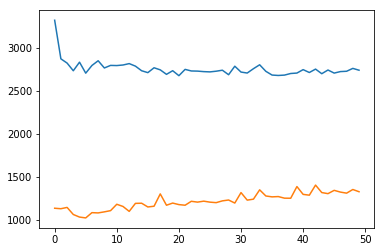

In [48]:
import matplotlib.pyplot as plt

plt.plot(training_losses)
plt.plot(validation_losses)
plt.show()

In [49]:
model.eval()
hidden = model.init_hidden(64)
sample_batch = sample_batch.to(device)
for each in hidden:
    each.to(device)
dense_out, _ = model.forward(sample_batch, hidden)
print(dense_out)

tensor([[56.3199],
        [56.3195],
        [56.3199],
        [56.3203],
        [56.3203],
        [56.3201],
        [56.3202],
        [56.3203],
        [56.3201],
        [56.3196],
        [56.3203],
        [56.3203],
        [56.3201],
        [56.3203],
        [56.3197],
        [56.3203],
        [56.3204],
        [56.3188],
        [56.3202],
        [56.3203],
        [56.3203],
        [56.3200],
        [56.3203],
        [56.3206],
        [56.3195],
        [56.3203],
        [56.3203],
        [56.3204],
        [56.3203],
        [56.3163],
        [56.3203],
        [56.3203],
        [56.3203],
        [56.3199],
        [56.3195],
        [56.3199],
        [56.3203],
        [56.3203],
        [56.3201],
        [56.3202],
        [56.3203],
        [56.3201],
        [56.3196],
        [56.3203],
        [56.3203],
        [56.3201],
        [56.3203],
        [56.3197],
        [56.3203],
        [56.3204],
        [56.3188],
        [56.3202],
        [56.